### Introduction

This notebook is an experiment of building a model that will predict if a rookie player will last at least 5 years in the league based on his stats.

In the National Basketball Association (NBA), a rookie is any player who has never played a game in the NBA until that year. At the end of the season the NBA awards the best rookie with the NBA Rookie of the Year Award.

Moving to the NBA league is a big deal for any basketball player. Sport commentators and fans are very excited to follow the start of their careers and guess how they will perform in the future.

In this experiment, LogisticRegression model is used.

### Import the libraries

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import os
import sys
sys.path.append(os.path.abspath('..'))
from src.common_lib import DataReader, NBARawData

from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
from joblib import dump
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In C:\Hnin\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Hnin\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Hnin\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Hnin\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Hnin\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.jpeg_quality rc

### Load the data

In [3]:
# Instantiate the custom data reader class
data_reader = DataReader()

# Load Raw Train Data
train_df = data_reader.read_data(NBARawData.TRAIN)

# Load Test Raw Data
test_df = data_reader.read_data(NBARawData.TEST)

### Scaling with Standard Scaler

In [4]:
scaler = StandardScaler()
df_cleaned = train_df.copy()
df_cleaned.columns = df_cleaned.columns.str.strip()
target = df_cleaned.pop('TARGET_5Yrs')

df_train_cleaned = scaler.fit_transform(df_cleaned)
df_train_cleaned

df_train_cleaned = pd.DataFrame(df_train_cleaned)
df_train_cleaned.columns = df_cleaned.columns

### Feature Selection

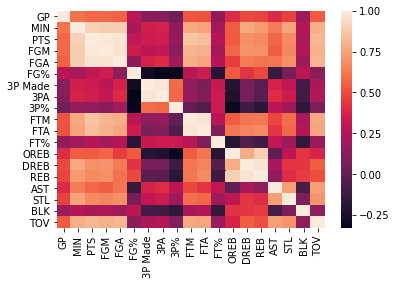

In [5]:
# Invoke the common function to do feature selection by correlation, Please run only once
# Features with corr > 0.9 are removed
selected_features = data_reader.select_feature_by_correlation(df_train_cleaned)

In [11]:
selected_features

Index(['GP', 'MIN', 'FG%', '3P Made', '3P%', 'FTM', 'FT%', 'OREB', 'DREB',
       'AST', 'STL', 'BLK', 'TOV'],
      dtype='object')

### Split the data with selected Features

In [12]:
# Filter out the Columns according to Corr Results
train_df  = df_train_cleaned[selected_features]

X_train, X_val, y_train, y_val = train_test_split(train_df, target, test_size = 0.2, random_state=8 )
X_train

# # Polynomialise
poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.fit_transform(X_val)

### Build the Logistic Regression Model

In [13]:
log_reg = LogisticRegression().fit(X_train_poly, y_train)
dump(log_reg,  '../models/tin_scale_poly_logistic_regression_02.joblib')

C:\Hnin\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


['../models/tin_scale_poly_logistic_regression_02.joblib']

### Prediction and Model Performance Evaluation

In [14]:
# Get Model Prediction Probability on Training Set
y_prob=log_reg.predict_proba(X_train_poly)[:,1]
y_prob
# Check Accuracy Score
y_pred=log_reg.predict(X_train_poly)
accuracy_score(y_train, y_pred)

0.8346875

In [15]:
# Get Model Prediction Probability on Validation Set
y_prob=log_reg.predict_proba(X_val_poly)[:,1]

# Check Accuracy Score
y_pred=log_reg.predict(X_val_poly)
accuracy_score(y_val, y_pred)  # 0.836875 last,

0.84

### Prediction on Test Data

In [16]:
test_df_cleaned = scaler.fit_transform(test_df)

test_df_cleaned = pd.DataFrame(test_df_cleaned)
test_df_cleaned.columns = test_df.columns
test_df_cleaned

test_df_cleaned = test_df_cleaned[selected_features]


X_test_poly = poly.fit_transform(test_df_cleaned) # Apply Polynomial
y_test_proba =log_reg.predict_proba(X_test_poly)[:,1]

final_prediction_test = pd.DataFrame({'Id': range(0,3799), 'TARGET_5Yrs': [p for p in y_test_proba]})

final_prediction_test.to_csv("../reports/tin_submission_scale_poly_logistic_regression_feature_selection.csv", index=False)

final_prediction_test.head(10)
## Kaggle Score .712

,Id,TARGET_5Yrs
0,0,0.824383
1,1,0.757458
2,2,0.947858
3,3,0.978797
4,4,0.769770
5,5,0.869938
6,6,0.754504
7,7,0.795189
8,8,0.863514
9,9,0.719155
